## Introduction to NLP

We will cover *practical* NLP:

* how to process text
* how to do useful things with it

... we will not cover *theoretical* NLP:

* grammars, syntax, linguistic models
* (sorry Noam)

# Why NLP?

<img src="img/why_nlp_slide.png" width=500>

# Why is NLP hard?

<img src="img/newspaper_san_jose.jpg" width=500>

<img src="img/crash_blossoms.jpg" width=500>

[Garden-path sentence (wiki)](https://en.wikipedia.org/wiki/Garden-path_sentence)

* ambiguous
* complex
* context dependent
* requires prior knowledge
* requires a world model
* is used for interaction with people (amusing, insulting)

## Famous NLP successes

- [GPT-3](https://en.wikipedia.org/wiki/GPT-3)
- [Google Translate](https://en.wikipedia.org/wiki/Google_Neural_Machine_Translation)
- [AI Dungeon](https://play.aidungeon.io/)
- [DALL-E](https://openai.com/blog/dall-e/)

# Words as data

* Start with a few sentences (our data)

In [172]:
sentences = [
    'We had a good time.',
    'This was a good-looking place.',
    'A once in a lifetime experience.',
    'Horrible.',
    'One of the worst experiences of my life.',
    "Everything went terribly, I'll never return."
]
y = [1, 1, 1, 0, 0, 0]

* We need to transform `sentence` into a matrix of features (`X`)
* How would you do this?

# Many ways to skin a cat!

* Memorize the sentences

In [118]:
model = {sentences[i]: y[i] for i in range(len(sentences))}
match = [model[sentence] == y[i] for i, sentence in enumerate(sentences)]
print(f'{sum(match) / len(sentences):3.1%} accuracy.')

100.0% accuracy.


<img src="https://media.giphy.com/media/26ufq9mryvc5HI27m/giphy.gif" width=500>

# What if we try a new sentence..

In [120]:
sentences_test = [
    'This was fun!',
    'Abysmal service.'
]
y_test = [1, 0]

In [168]:
match = [model[sentence] == y[i] for i, sentence in enumerate(sentences_test)]
print(f'{sum(match) / len(sentences_test):3.1%} accuracy.')

KeyError: 'This was fun!'

Our model failed at out of sample data. Clearly we need a new approach!

Sentences are just too specific. What if we picked a more generic, broadly applicable symbol? Characters come to mind!

# Many ways to skin a cat!

* One feature for every letter in the alphabet
* Use a decision tree!

In [143]:
import numpy as np

from sklearn import tree

# used to display trees
import pydotplus
from IPython.display import Image

%matplotlib inline

def create_graph(mdl, cmap=None, feature_names=None):
    # cmap is a colormap
    # e.g. cmap = matplotlib.cm.coolwarm( np.linspace(0.0, 1.0, 256, dtype=float) )
    tree_graph = tree.export_graphviz(mdl, out_file=None,
                             feature_names=feature_names,
                             filled=True, rounded=True)
    graph = pydotplus.graphviz.graph_from_dot_data(tree_graph)
    
    # get colormap
    if cmap:
        # remove transparency
        if cmap.shape[1]==4:
            cmap = cmap[:,0:2]
        
        nodes = graph.get_node_list()
        for node in nodes:
            if node.get_label():
                # get number of samples in group 1 and group 2
                num_samples = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]

                # proportion that is class 2
                cm_value = float(num_samples[1]) / float(sum(num_samples))
                # convert to (R, G, B, alpha) tuple
                cm_value = matplotlib.cm.coolwarm(cm_value)
                cm_value = [int(np.ceil(255*x)) for x in cm_value]
                color = '#{:02x}{:02x}{:02x}'.format(cm_value[0], cm_value[1], cm_value[2])
                node.set_fillcolor(color)

    Image(graph.create_png())
    return graph

In [479]:
def prepare_data(sentences, alphabet='abcdefghijklmnopqrstuvwxyz'):
    return [[a in sentence for a in alphabet] for sentence in sentences]
    
X = prepare_data(sentences)

mdl = tree.DecisionTreeClassifier(max_depth=3)

# fit the model to the data - trying to predict y from X
mdl = mdl.fit(X, y)

ValueError: Number of labels=25000 does not match number of samples=6

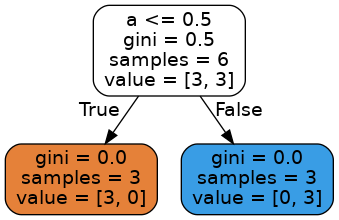

In [145]:
graph = create_graph(mdl, feature_names=list('abcdefghijklmnopqrstuvwxyz'))
Image(graph.create_png())

In [481]:
print([(y[i], sentence) for i, sentence in enumerate(sentences)])

[(0.0, 'We had a good time.'), (0.0, 'This was a good-looking place.'), (0.0, 'A once in a lifetime experience.'), (0.0, 'Horrible.'), (0.0, 'One of the worst experiences of my life.'), (0.0, "Everything went terribly, I'll never return.")]


# Try our model on new data

In [482]:
X_test = prepare_data(sentences_test)
pred_test = mdl.predict(X_test)

match = [pred_test[i] == y_test[i] for i, sentence in enumerate(sentences_test)]
print(f'{sum(match) / len(sentences_test):3.1%} accuracy.')
print([(pred_test[i], sentence) for i, sentence in enumerate(sentences_test)])

AttributeError: 'DecisionTreeClassifier' object has no attribute 'tree_'

* That's... bad.

# NLP has many levels

* Symbol/Character
* Lexeme
* Word
* Sentence
* etc...
  * *Paragraph*, *Document*, *Corpus*, ...

# NLP has many levels

* Symbol/Character
* Lexeme
* Word
* Sentence

# NLP has many levels

* ~Symbol/Character~ - too low level
* ~Lexeme~ - we don't know what this means
* Word
* ~Sentence~ - too high level

# Words as data

* Our "alphabet" becomes all the words we've seen


In [174]:
import itertools

alphabet = sorted(list(set([word for sentence in sentences for word in sentence.split(' ')])))
print(alphabet)

['A', 'Everything', 'Horrible.', "I'll", 'One', 'This', 'We', 'a', 'experience.', 'experiences', 'good', 'good-looking', 'had', 'in', 'life.', 'lifetime', 'my', 'never', 'of', 'once', 'place.', 'return.', 'terribly,', 'the', 'time.', 'was', 'went', 'worst']


The above list.. isn't great.

* punctuation included in words
* "experience" and "experiences" separate
* "A" and "a" are different
* "good-looking" vs "good"

> Hrm, that's annoying.

*This should be the motto for NLP.*

# Words as data

* Focus on the word "good-looking".
* Should we split this into two words, "good" and "looking"?
* What about `I'll`? Strictly speaking, it's two words: `I` and `will`.

# Tokenization

* In NLP, we don't work with "words", we work with "tokens"
* *Tokens* are groups of symbols with some semantic meaning
* Tokenization is the process of converting text into individual tokens

# Tokenizers

* spaCy's English tokenizer
* Stanford's nltk
* WordPiece Tokenizer
* ... etc

# Trying it out

We'll work with spaCy's tokenizer.

In [180]:
# download the English model we will use - only needs to be run once
# this model is small (~7 MB)
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 6.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [182]:
import spacy
nlp = spacy.load("en_core_web_sm") # load an English model we already downloaded

In [191]:
for sentence in sentences:
    doc = nlp(sentence)
    print(sentence, end=': ')
    print([token for token in doc])

We had a good time.: [We, had, a, good, time, .]
This was a good-looking place.: [This, was, a, good, -, looking, place, .]
A once in a lifetime experience.: [A, once, in, a, lifetime, experience, .]
Horrible.: [Horrible, .]
One of the worst experiences of my life.: [One, of, the, worst, experiences, of, my, life, .]
Everything went terribly, I'll never return.: [Everything, went, terribly, ,, I, 'll, never, return, .]


# Trying it out

We can try other sentences to explore the tokenizer's quirks.

In [196]:
sentence = "To be or not to be; that is the question. Or at least it was Hamlet's question."
doc = nlp(sentence)
print([token for token in doc])

[To, be, or, not, to, be, ;, that, is, the, question, ., Or, at, least, it, was, Hamlet, 's, question, .]


# IMDb

Let's try out spaCy's tokenizer on a large dataset from IMDb curated by researchers [1].

- 50,000 reviews of movies on IMDB
- 25,000 positive reviews (>=7), 25,000 negative reviews (<=4)
- Dataset commonly used for sentiment classification

> [1] Maas A, Daly RE, Pham PT, Huang D, Ng AY, Potts C. Learning word vectors for sentiment analysis. In Proceedings of the 49th annual meeting of the association for computational linguistics: Human language technologies 2011 Jun (pp. 142-150).

In [ ]:
import os
from pathlib import Path
from tqdm.notebook import tqdm

def load_data(path):
    corpus = {}
    files = os.listdir(path)
    for fn in tqdm(files):
        filename = path / fn
        with open(filename, 'r') as fp:
            text = ''.join(fp.readlines())
        corpus[filename.stem] = text
    
    return corpus

print('Loading positive documents (training set).')
pos = load_data(Path('aclImdb/train/pos'))
print('Loading negative documents (training set).')
neg = load_data(Path('aclImdb/train/neg'))

print('Loading positive documents (test set).')
pos_test = load_data(Path('aclImdb/test/pos'))
print('Loading negative documents (test set).')
neg_test = load_data(Path('aclImdb/test/neg'))

In [384]:
def get_numpy_arrays(pos, neg):
    # create numpy arrays of the datasets
    X_pos = np.array(list(pos.values()))
    X_neg = np.array(list(neg.values()))
    X = np.hstack([X_pos, X_neg])
    n_pos, n_neg = X_pos.shape[0], X_neg.shape[0]
    y = np.concatenate([np.ones(n_pos), np.zeros(n_neg)])
    return X, y

# only use ~1000 examples for speed
X_train, y_train = get_numpy_arrays(
    {k: v for k, v in pos.items() if k.startswith('2')},
    {k: v for k, v in neg.items() if k.startswith('2')}
)
X_test, y_test = get_numpy_arrays(
    {k: v for k, v in pos_test.items() if k.startswith('2')},
    {k: v for k, v in neg_test.items() if k.startswith('2')}
)

## Example review

In [385]:
print(pos['10_9'])

I'm a male, not given to women's movies, but this is really a well done special story. I have no personal love for Jane Fonda as a person but she does one Hell of a fine job, while DeNiro is his usual superb self. Everything is so well done: acting, directing, visuals, settings, photography, casting. If you can enjoy a story of real people and real love - this is a winner.


<img src="img/fonda_deniro_Stanley_And_Iris_1990.png" width=500>

[Stanley and Iris](https://www.imdb.com/title/tt0100680/?ref_=tt_urv)

# Text classification

* Recall, the goal of this exercise was to *classify text*
  * classify e-mails as spam or not spam
  * tweets as inappropriate or appropriate
* We are trying to create a matrix `X` to classify targets `y`

## Tokenize the review

In [386]:
doc = nlp(review)
print([token for token in doc])

[I, 'm, a, male, ,, not, given, to, women, 's, movies, ,, but, this, is, really, a, well, done, special, story, ., I, have, no, personal, love, for, Jane, Fonda, as, a, person, but, she, does, one, Hell, of, a, fine, job, ,, while, DeNiro, is, his, usual, superb, self, ., Everything, is, so, well, done, :, acting, ,, directing, ,, visuals, ,, settings, ,, photography, ,, casting, ., If, you, can, enjoy, a, story, of, real, people, and, real, love, -, this, is, a, winner, .]


* `'m` and `'s` are given their own token
* punctuation marks are individual tokens
* whitespaces are individual tokens

As you can see, tokens *do not have to be words*!

... how do we turn this into `X`?

# Creating the data matrix

* Recall when we used the alphabet
* Each column was a letter
* Each row was our sentence (now review)
  * `X[i,j] == 0` -> letter is in the document
  * `X[i,j] == 1` -> letter is not in the document

In [387]:
columns = list('abcdefghijklmnopqrstuvwxyz')
print(f'{len(columns)} columns: {columns}')

26 columns: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


* We are using tokens instead of letters
* Which tokens should we include as columns?

# Vocabulary

* The set of tokens we choose is our *vocabulary*.
* Most vocabularies consist of the most common tokens.

In [ ]:
https://github.com/vocapouch/vocapouch-research/blob/master/books/Book%20Coverage.ipynb

We can grab the 10 most frequently used tokens in the IMDb dataset.

What do you think the top 10 tokens are?



Number of Pages: 250
Number of Total Words: 75208
Number of Unique Words: 5248
You will know 90% of words after 40 pages which are 16.00% of the book.
At that page, you will know 39.21% of unique words.



In [ ]:


Number of Pages: 729
Number of Total Words: 218793
Number of Unique Words: 50872
You will know 90% of words after 387 pages which are 53.09% of the book.
At that page, you will know 60.64% of unique words.



In [388]:
from collections import Counter

token_freq = Counter()

for corpus in [pos, neg]:
    for text in tqdm(corpus.values(), total=len(corpus)):
        # only call the tokenizer for speed purposes
        doc = nlp.tokenizer(text)
        
        for token in doc:
            # use 'orth', the integer version of the string
            # will convert back to string version later
            token_freq[token.orth] += 1

# convert back to string
token_freq = Counter({nlp.vocab.strings[k]: v for k, v in token_freq.items()})

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

useless maps

In [389]:
token_freq.most_common(10)

[('the', 289838),
 (',', 275296),
 ('.', 236702),
 ('and', 156484),
 ('a', 156282),
 ('of', 144056),
 ('to', 133886),
 ('is', 109095),
 ('in', 87676),
 ('I', 77546)]

# Stop-words

* The tokens "the", ",", etc have little meaning on their own
* We call these "stop-words".
* Let's remove them for now.

Why are these stop-words not useful for our current approach?

We've destroyed the document structure! The existence of punctuation is almost always meaningless.

## Using sklearn for modelling

* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [User Guide on text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [392]:
from spacy.tokens import Token
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics

def train_pipe_and_predict(pipe, X_train, y_train, X_test):
    """Convenience function for training pipeline."""
    print('Building model.')
    pipe.fit(X_train, y_train)

    print('Getting test predictions.')

    # Predicting with a test dataset
    pred = pipe.predict(X_test)
    
    return pred

def print_results(y_test, pred):
    # Model Accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_test, pred):3.1%}")
    print(f"Precision: {metrics.precision_score(y_test, pred):3.1%}")
    print(f"Recall: {metrics.recall_score(y_test, pred):3.1%}")

def introspect_text(pipe, text):
    print(text, end='\n\n')
    vectorizer = pipe.named_steps['vectorizer']
    freq = vectorizer.transform([text])[0].toarray()
    features = vectorizer.get_feature_names()
    
    # get the prediction
    pred = pipe.predict([text])
    if pred[0] == 0:
        print('Prediction: NEGATIVE.')
    else:
        print('Prediction: POSITIVE.')
    for i, feat in enumerate(features):
        print(f'{feat:10s} {freq[0][i]:3d}')

In [391]:
def spacy_tokenizer(text):
    return [token.text for token in nlp.tokenizer(text)]

In [405]:
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer, max_features=10)),
                 ('classifier', tree.DecisionTreeClassifier(max_depth=3))])

# pipeline will be updated in-place!
pred = train_pipe_and_predict(pipe, X_train, y_train, X_test)

Building model.
Getting test predictions.


Accuracy: 63.0%
Precision: 63.2%
Recall: 62.2%


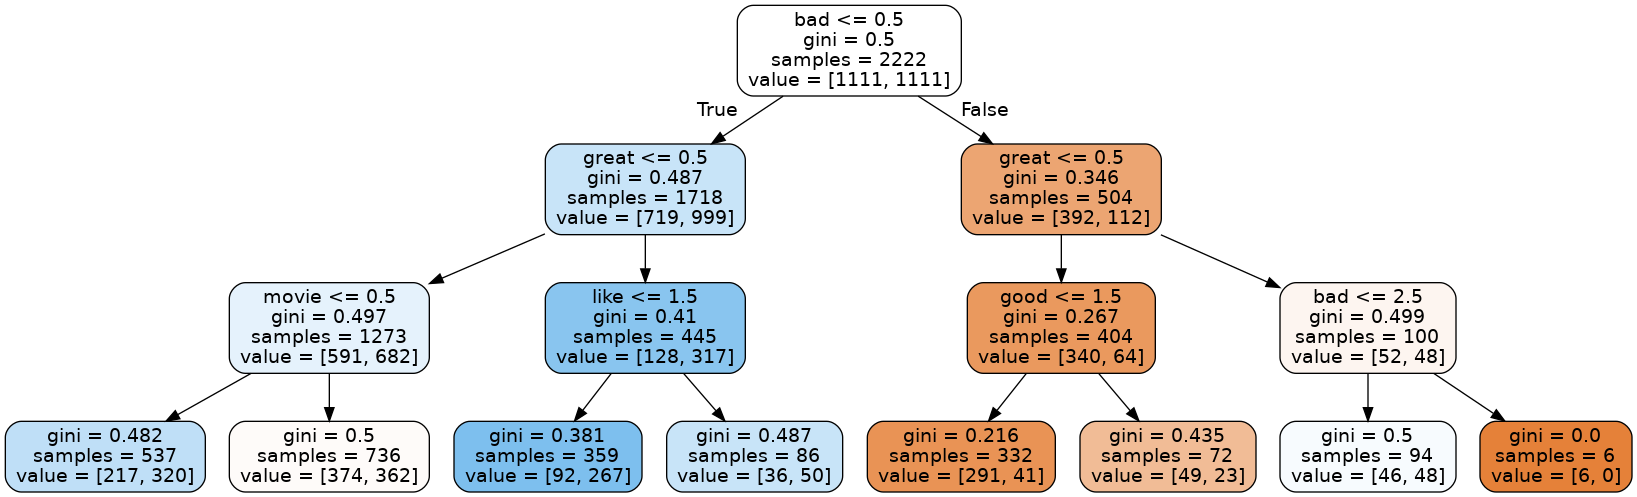

In [406]:
# Model Accuracy
print_results(y_test, pred)

vectorizer = pipe.named_steps['vectorizer']
classifier = pipe.named_steps['classifier']

graph = create_graph(classifier, feature_names=vectorizer.get_feature_names())
Image(graph.create_png())

In [407]:
text = pos['10_9']
print(text, end='\n\n')
freq = vectorizer.transform([text])[0].toarray()
features = vectorizer.get_feature_names()
for i, feat in enumerate(features):
    print(f'{feat:10s} {freq[0][i]:3d}')

I'm a male, not given to women's movies, but this is really a well done special story. I have no personal love for Jane Fonda as a person but she does one Hell of a fine job, while DeNiro is his usual superb self. Everything is so well done: acting, directing, visuals, settings, photography, casting. If you can enjoy a story of real people and real love - this is a winner.

/><br        0
bad          0
film         0
good         0
great        0
like         0
movie        0
people       1
story        2
time         0


# Stop words

* We can try to remove the stop words and see how the model improves
* Also remove punctuation, for the same reason

In [408]:
def spacy_tokenizer(text):
    return [token.text for token in nlp.tokenizer(text) if not token.is_punct and not token.is_stop]

In [409]:
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer, max_features=10)),
                 ('classifier', tree.DecisionTreeClassifier(max_depth=3))])

pred = train_pipe_and_predict(pipe, X_train, y_train, X_test)

Building model.
Getting test predictions.


Accuracy: 63.0%
Precision: 63.2%
Recall: 62.2%


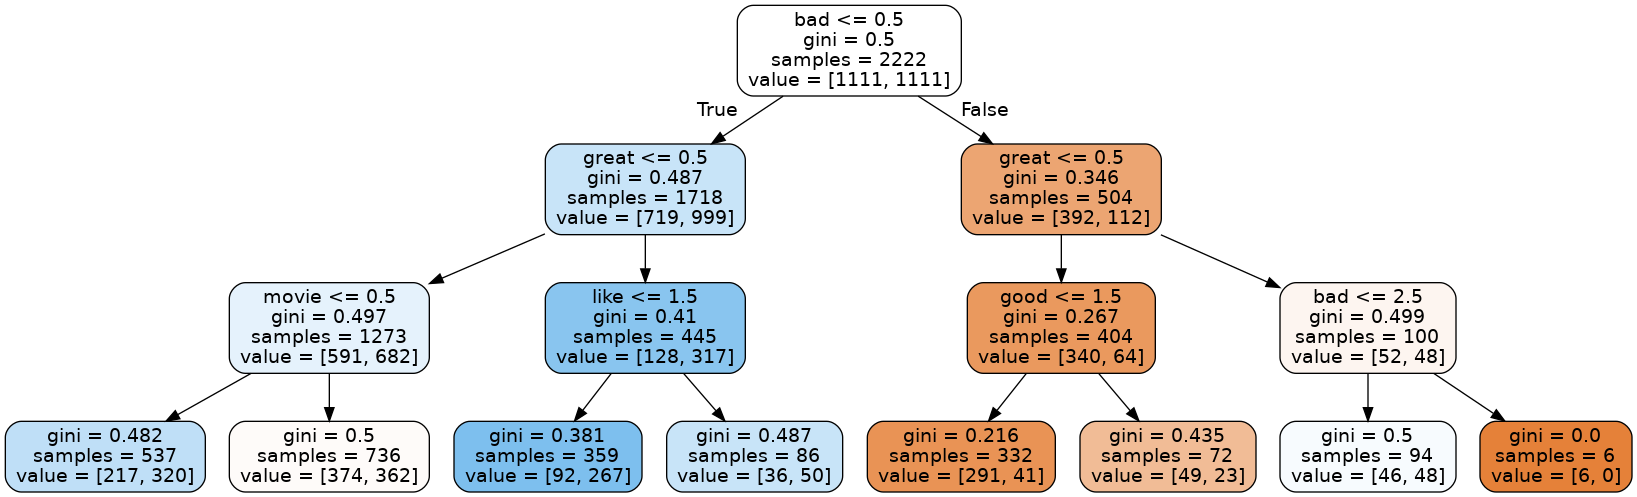

In [410]:
print_results(y_test, pred)

vectorizer = pipe.named_steps['vectorizer']
classifier = pipe.named_steps['classifier']

graph = create_graph(classifier, feature_names=vectorizer.get_feature_names())
Image(graph.create_png())

In [411]:
text = pos['10_9']
introspect_text(pipe, text)

I'm a male, not given to women's movies, but this is really a well done special story. I have no personal love for Jane Fonda as a person but she does one Hell of a fine job, while DeNiro is his usual superb self. Everything is so well done: acting, directing, visuals, settings, photography, casting. If you can enjoy a story of real people and real love - this is a winner.

Prediction: POSITIVE.
/><br        0
bad          0
film         0
good         0
great        0
like         0
movie        0
people       1
story        2
time         0


# Increase the vocabulary size

In [414]:
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer, max_features=20)),
                 ('classifier', tree.DecisionTreeClassifier(max_depth=3))])

pred = train_pipe_and_predict(pipe, X_train, y_train, X_test)

Building model.
Getting test predictions.


Accuracy: 63.2%
Precision: 68.9%
Recall: 48.2%


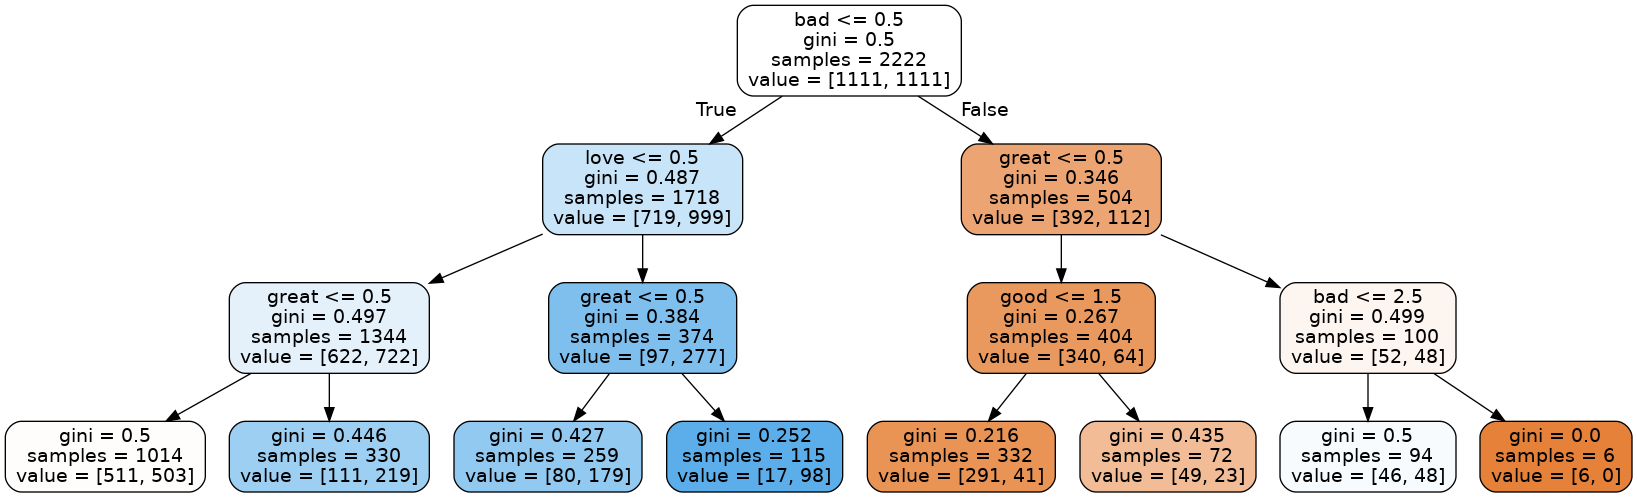

In [415]:
print_results(y_test, pred)

vectorizer = pipe.named_steps['vectorizer']
classifier = pipe.named_steps['classifier']

graph = create_graph(classifier, feature_names=vectorizer.get_feature_names())
Image(graph.create_png())

In [416]:
text = pos['10_9']
introspect_text(pipe, text)

I'm a male, not given to women's movies, but this is really a well done special story. I have no personal love for Jane Fonda as a person but she does one Hell of a fine job, while DeNiro is his usual superb self. Everything is so well done: acting, directing, visuals, settings, photography, casting. If you can enjoy a story of real people and real love - this is a winner.

Prediction: POSITIVE.
/><br        0
/>the        0
<            0
acting       1
bad          0
br           0
film         0
films        0
good         0
great        0
like         0
love         2
movie        0
movies       1
people       1
story        2
think        0
time         0
watch        0
way          0


Aha! We have the same words occurring as distinct features!

# Stemming

- Many words have similar meaning but distinct morphology
  * this was entertaining // i was entertained
- Removing the end of the word is effective in grouping like terms
  * movies -> movie
  * entertaining -> entertain
- This process is called "stemming"

# Stemming implementations

* [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/): Most common, non-aggressive
* [Snowball Stemmer](https://tartarus.org/martin/PorterStemmer/): Improvement over Porter Stemmer

[Snowball Stemmer implementation is on GitHub](https://github.com/snowballstem/snowball/blob/master/python/snowballstemmer/basestemmer.py).

```
define Step_2 as (
    [substring] R1 among (
        'tional'  (<-'tion')
        'enci'    (<-'ence')
        'anci'    (<-'ance')
```


In [417]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

def spacy_tokenizer(text):
    return [stemmer.stem(token.text) for token in nlp.tokenizer(text) if not token.is_punct and not token.is_stop]

In [419]:
# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer, max_features=20)),
                 ('classifier', tree.DecisionTreeClassifier(max_depth=3))])

pred = train_pipe_and_predict(pipe, X_train, y_train, X_test)

Building model.
Getting test predictions.


Current best: 63.2%.

Accuracy: 65.8%
Precision: 72.8%
Recall: 50.2%


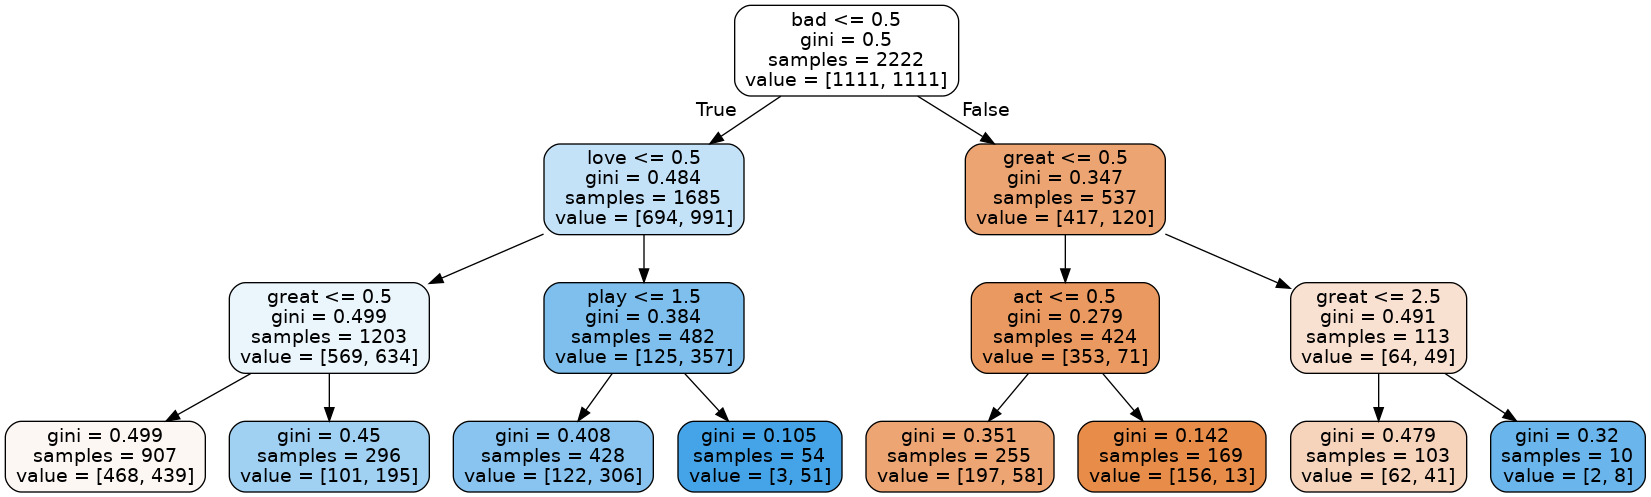

In [420]:
print_results(y_test, pred)

graph = create_graph(pipe.named_steps['classifier'], feature_names=pipe.named_steps['vectorizer'].get_feature_names())
Image(graph.create_png())

In [421]:
text = pos['10_9']
introspect_text(pipe, text)

I'm a male, not given to women's movies, but this is really a well done special story. I have no personal love for Jane Fonda as a person but she does one Hell of a fine job, while DeNiro is his usual superb self. Everything is so well done: acting, directing, visuals, settings, photography, casting. If you can enjoy a story of real people and real love - this is a winner.

Prediction: POSITIVE.
/><br        0
act          1
bad          0
charact      0
end          0
film         0
good         0
great        0
like         0
look         0
love         2
movi         1
peopl        1
play         0
scene        0
stori        2
think        0
time         0
watch        0
way          0


* No longer dictionary words
* words like character and characters are combined into charact
* words like play and playing are also combined

# Lemmatization

* With stemming, we applied an algorithm to simplify the text
* With lemmatization, we use *knowledge* - a lexicon
  * swing == swung

In [376]:
text = pos['10_9']
doc = nlp(text)
for token in doc[:4]:
    print(f'{token.text:15s} -> {token.lemma_:15s}')

I               -> I              
'm              -> be             
a               -> a              
male            -> male           


In [423]:
def spacy_tokenizer(text):
    # note we call nlp(text) now
    # lemmatizing is slow compared to tokenizing!
    return [token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_stop]

In [425]:
# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer, max_features=20)),
                 ('classifier', tree.DecisionTreeClassifier(max_depth=3))])

pred = train_pipe_and_predict(pipe, X_train, y_train, X_test)

Building model.
Getting test predictions.


In [ ]:
Current best: 65.8%

Accuracy: 68.2%
Precision: 63.0%
Recall: 88.1%


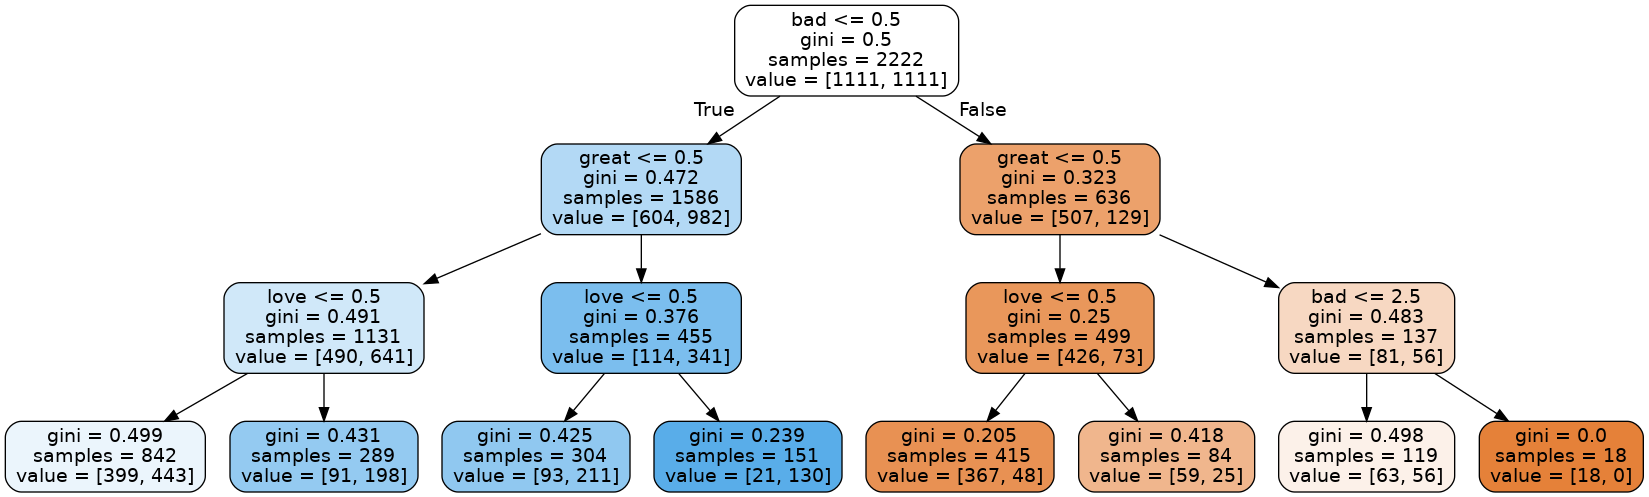

In [426]:
print_results(y_test, pred)

graph = create_graph(pipe.named_steps['classifier'], feature_names=pipe.named_steps['vectorizer'].get_feature_names())
Image(graph.create_png())

# What else could we do to improve performance?

I'm going to skin a cat.

<img src="img/scared_cat.png" width="300">

There's more than one way to skin a cat.

<img src="https://media.giphy.com/media/z23hGvopHu7w4/giphy.gif">

> I'm going to **skin a cat**

> More than one way to **skin a cat**

* Context matters
* Words take on new meaning when used with other, specific words

# Word combinations have meaning

* "hidden gem"

<img src="img/hidden_gem.jpeg" width=300>

* So far we have one feature per token
* What if we had a feature for pairs of tokens?
  * -> token bigrams


In [427]:
# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer, max_features=20, ngram_range=(1, 2))),
                 ('classifier', tree.DecisionTreeClassifier(max_depth=3))])

pred = train_pipe_and_predict(pipe, X_train, y_train, X_test)

Building model.
Getting test predictions.


Accuracy: 68.2%
Precision: 63.0%
Recall: 88.1%


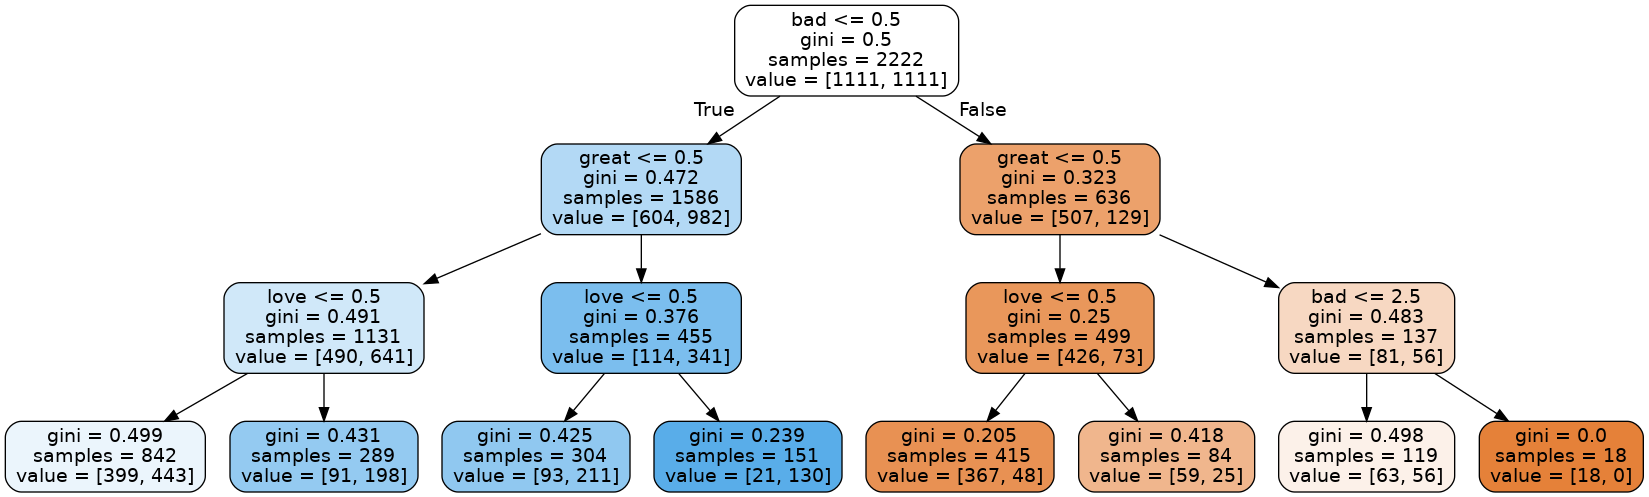

In [428]:
print_results(y_test, pred)

graph = create_graph(pipe.named_steps['classifier'], feature_names=pipe.named_steps['vectorizer'].get_feature_names())
Image(graph.create_png())

# What else could we do to improve performance?

... whatever we can think of!

Let's look at an example from a recent paper.

# Named Entity Recognition

Classify the individual tokens in a text.

In [437]:
text = "Alistair Johnson saw me last Monday the 24th."
targets = ['NAME', 'NAME', 'O', 'O', 'O', 'DATE', 'DATE', 'DATE']

for i, token in enumerate(text.split(' ')):
    print(f'{token:15s}{targets[i]}')

Alistair       NAME
Johnson        NAME
saw            O
me             O
last           O
Monday         DATE
the            DATE
24th.          DATE


In [439]:
for i, token in enumerate(text.split(' ')):
    print(f'{token:15s} -> x -> f(x) ~= {targets[i]}')

Alistair        -> x -> f(x) ~= NAME
Johnson         -> x -> f(x) ~= NAME
saw             -> x -> f(x) ~= O
me              -> x -> f(x) ~= O
last            -> x -> f(x) ~= O
Monday          -> x -> f(x) ~= DATE
the             -> x -> f(x) ~= DATE
24th.           -> x -> f(x) ~= DATE


<img src="img/deid_approach.jpg" width=400>

[1] Lee HJ, Wu Y, Zhang Y, Xu J, Xu H, Roberts K. A hybrid approach to automatic de-identification of psychiatric notes. Journal of biomedical informatics. 2017 Nov 1;75:S19-27.
https://doi.org/10.1016/j.jbi.2017.06.006

* **Bag-of-words**: unigrams, bigrams and trigrams of words within a window of [-2, 2].

In [449]:
unigrams = ['Monday', 'Tuesday']
print(f'{"Entity":15s} -> [{", ".join(unigrams)}, ...]')
tokens = text.split(' ')
for i, token in enumerate(tokens):
    start, stop = max(i-2, 0), min(i+2+1, len(tokens))
    feature = [gram in tokens[start:stop] for gram in unigrams]
        
    print(f'{token:15s} -> {", ".join(map(str, feature))}, ...')

Entity          -> [Monday, Tuesday, ...]
Alistair        -> False, False, ...
Johnson         -> False, False, ...
saw             -> False, False, ...
me              -> True, False, ...
last            -> True, False, ...
Monday          -> True, False, ...
the             -> True, False, ...
24th.           -> True, False, ...


* **Bag-of-words**: unigrams, bigrams and trigrams of words within a window of [-2, 2].
* **Part-of-speech (POS) tags**: unigrams, bigrams and trigrams of POS tags within a window of [−2, 2]. The Stanford POS Tagger [42] was used for POS tagging.

In [451]:
# we need dependency parsing
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)

from spacy import displacy
displacy.render(doc, style='dep', jupyter=True)

* **Bag-of-words**: unigrams, bigrams and trigrams of words within a window of [-2, 2].
* **Part-of-speech (POS) tags**: unigrams, bigrams and trigrams of POS tags within a window of [−2, 2]. The Stanford POS Tagger [42] was used for POS tagging.
* **Combinations of words and POS tags**: combining current word with the unigrams, bigrams and trigrams of POS tags within a window of [−1, 1], i.e. w0p−1, w0p0, w0p1, w0p−1p0, w0p0p1, w0p−1p1, w0p−1p0p1, where w0, p−1, p0 and p1 denote current word, last, current and next POS tags respectively.
* **Sentence information**: number of words in current sentence, whether there is an end mark at the end of current sentence such as ’.’, ’?’ and ’!’, whether there is any bracket unmatched in current sentence.
* **Affixes**: prefixes and suffixes of length from 1 to 5.
* **Orthographical features**: whether the word is upper case, contains uppercase characters, contains punctuation marks, contains digits, etc.
* **Word shapes**: mapping any or consecutive uppercase character(s), lowercase character(s), digit(s) and other character(s) in current word to ’ A’, ’ a’, ’ #’ and ’ -’ respectively. For instance, the word shapes of “Hospital” are “Aaaaaaaa” and “Aa”.

* **Word shapes**: mapping any or consecutive uppercase character(s), lowercase character(s), digit(s) and other character(s) in current word to ’ A’, ’ a’, ’ #’ and ’ -’ respectively. For instance, the word shapes of “Hospital” are “Aaaaaaaa” and “Aa”.

In [454]:
word_shapes = []
for token in tokens:
    shape = ''
    for letter in token:
        if letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
            shape += 'A'
        elif letter in 'abcdefghijklmnopqrstuvwxtz':
            shape += 'a'
        elif letter in '0123456789':
            shape += '#'
        else:
            shape += '-'
    word_shapes.append(shape)
    print(f'{token:15s} {shape}')

Alistair        Aaaaaaaa
Johnson         Aaaaaaa
saw             aaa
me              aa
last            aaaa
Monday          Aaaaa-
the             aaa
24th.           ##aa-


* Error prone
* Laborious
* Inefficient

# Regular expressions (regex)

* Regex: match patterns in text
    * Concise and powerful pattern matching language
    * Supported by many computer languages, including SQL
* Challenges
    * Brittle
    * Hard to write, can get complex to be correct
    * Hard to read


In [461]:
import re

text_modified = str(text)
print(text_modified)

Alistair Johnson saw me last Monday the 24th.


In [462]:
text_modified = re.sub('[A-Z]', 'A', text_modified)
print(text_modified)

Alistair Aohnson saw me last Aonday the 24th.


In [463]:
text_modified = re.sub('[a-z]', 'a', text_modified)
print(text_modified)

Aaaaaaaa Aaaaaaa aaa aa aaaa Aaaaaa aaa 24aa.


In [464]:
text_modified = re.sub('[0-9]', '#', text_modified)
print(text_modified)

Aaaaaaaa Aaaaaaa aaa aa aaaa Aaaaaa aaa ##aa.


In [465]:
text_modified = re.sub('[^Aa# ]', '-', text_modified)
print(text_modified)

Aaaaaaaa Aaaaaaa aaa aa aaaa Aaaaaa aaa ##aa-


* **Bag-of-words**: unigrams, bigrams and trigrams of words within a window of [-2, 2].
* **Part-of-speech (POS) tags**: unigrams, bigrams and trigrams of POS tags within a window of [−2, 2]. The Stanford POS Tagger [42] was used for POS tagging.
* **Combinations of words and POS tags**: combining current word with the unigrams, bigrams and trigrams of POS tags within a window of [−1, 1], i.e. w0p−1, w0p0, w0p1, w0p−1p0, w0p0p1, w0p−1p1, w0p−1p0p1, where w0, p−1, p0 and p1 denote current word, last, current and next POS tags respectively.
* **Sentence information**: number of words in current sentence, whether there is an end mark at the end of current sentence such as ’.’, ’?’ and ’!’, whether there is any bracket unmatched in current sentence.
* **Affixes**: prefixes and suffixes of length from 1 to 5.
* **Orthographical features**: whether the word is upper case, contains uppercase characters, contains punctuation marks, contains digits, etc.
* **Word shapes**: mapping any or consecutive uppercase character(s), lowercase character(s), digit(s) and other character(s) in current word to ’ A’, ’ a’, ’ #’ and ’ -’ respectively. For instance, the word shapes of “Hospital” are “Aaaaaaaa” and “Aa”.
* **Section information**: twenty-nine section headers (see the supplementary file) were collected manually such as “History of Present Illness”; we check which section current word belongs to.
* **General NER information**: the Stanford Named Entity Recognizer [43] was used to generate the NER tags of current word, include: person, date, organization, location, and number tags, etc.

In [466]:
displacy.render(doc, style='ent', jupyter=True)

# Recap

- Tokenize: split text into individual meaningful units
- Pre-process: remove stop words, remove punctuation
- Stemming: remove the suffix of words to merge similar words together
- Lemmatize: use a lexicon to merge similar words together
- Extract features: do whatever you think makes sense!
  - [spaCy linguistic features](https://spacy.io/usage/linguistic-features)

spaCy pipeline

<img src="img/spacy_pipeline.svg" width=700>

https://spacy.io/usage/processing-pipelines

# How do I use this knowledge?

**Look at the data.**

In [488]:
n = 0
for k, v in pos.items():
    print('='*10)
    print(f'{k}\n---')
    print(v)
    print('='*10)
    n += 1
    if n >= 5:
        break

998_7
---
This is a really interesting movie. It is an action movie with comedy mixed in. Foxx teams up with comedian Epps in this movie to give it a comedic spin. It will keep you wondering whats going to happen to Foxx next. It was a well shot movie, the director used the right colors in this movie(dark blue colors) to give it the right kind of feel. Kimberly Elise also starred in this movie and it is always a pleasure to see her on the big screen. She plays her role well. Even Jamie Kennedy is in this movie. It's worth seeing it you haven't seen it. It's definitely worth having if you are a Jamie Foxx fan. It deserves more credit than it is actually given.
20_9
---
'Stanley and Iris' show the triumph of the human spirit. For Stanley, it's the struggle to become literate and realize his potential. For Iris, it's to find the courage to love again after becoming a widow. The beauty of the movie is the dance that Robert DeNiro and Jane Fonda do together, starting and stopping, before ea

In [489]:
n = 0
for k, v in neg.items():
    print('='*10)
    print(f'{k}\n---')
    print(v)
    print('='*10)
    n += 1
    if n >= 5:
        break

713_1
---
Can I please say first of all, that I felt so strongly about this movie that I signed up to IMDb specifically to review it. And my review? This is easily the worst movie I have ever seen.<br /><br />The synopsis of the movie sounded interesting- Nazis, occult, time travel, etc., but the movies plot failed to properly bring all these elements together. Remember the episode of South Park that featured manatees writing Family Guy using 'idea balls'? Did these manatees also write Unholy? Its like the writer wanted to include all these different ideas, but had no idea how to link them all together, and then to make things make even less sense, included a Donnie Darko-esquire time travel theme to the ending, messing up the chronology.<br /><br />I could tell from early on that this was a bad movie. Special effects were too low budget for anything better than straight to DVD. The acting wasn't great, but in fairness I've seen worse. I will praise the Nazi paintings, they were creepy

# Improving our token features

Let's pretend we have 3 token features.

In [490]:
text = 'The queen is doing a much better job than the king.'
columns = ['queen', 'king', 'bishop']

features = [int(c in text) for c in columns]
print(columns)
print(features)

['queen', 'king', 'bishop']
[1, 1, 0]


* We have a world model, and we know queen/king are similar concepts
* ... but in the features, they are totally separate
* we don't *share* knowledge between "queen" and "king"

# Distributional hypothesis

* Does language have a distributional structure? [1]

*structure*:

> A set of phonemes or a set of data is structured in respect to some feature, to the extent that we can form in terms of that feature some organized system of statements which describes the members of the set and their interrelations (at least up to some limit of complexity).

*distributional*:

> The distribution of an element will be understood as the sum of all its environments. An environment of an element A is an existing array of its co-occurrents, i.e. the other elements, each in a  particular position, with which A occurs to yield an utterance.

-> you're known by the company you keep

[1] Harris ZS. Distributional structure. Word. 1954 Aug 1;10(2-3):146-62.
[PDF](https://www.tandfonline.com/doi/pdf/10.1080/00437956.1954.11659520).

# Distributional hypothesis

We could manually create these features.

* "The queen of England" -> feature 1: England is mentioned nearby 
* "The king of Spain" -> feature 2: Spain is mentioned nearby
* "The queen of Russia" -> feature 3: some proper country is mentioned nearby
* "Ascended the throne as queen" -> feature 4: some regal stuff is nearby

... this would get exhausting.

# word2vec

Learn these features, rather than manually create them.

1. Take a whole bunch of text
2. Try to predict a word's *context* form the word itself ("skip-grams")
3. Use the model's representation of words (tokens)

(target word, context word)

<img src="img/word2vec_skipgram.png" width=400>

[1] https://www.tensorflow.org/tutorials/text/word2vec

This works great in theory - except we're going to end up with 10,000s of outputs for 10,000s of inputs.

Instead of predicting the *word*, let's just predict yes/no "is this word a neighbour?".

<img src='img/skipgram-with-negative-sampling.png' width="800">

[1] https://jalammar.github.io/illustrated-word2vec/

<img src='img/word_embeddings.png' width="800">

[1] https://jalammar.github.io/illustrated-word2vec/

# Download the word vectors

In [491]:
# 47.1 MB.
!python -m spacy download en_core_web_md

     |████████████████████████████████| 47.1 MB 4.8 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [500]:
nlp = spacy.load("en_core_web_md")
text = 'The queen is doing a much better job than the king.'
tokens = nlp(text)

vectors = []

for token in tokens:
    print(f'{token.text:10s}{token.has_vector} {token.vector_norm} {[f"{t:1.2f}" for t in token.vector[:5]]} ...')
    vectors.append(token.vector)

vectors = np.vstack(vectors)

The       True 4.709350109100342 ['0.27', '-0.06', '-0.19', '0.02', '-0.02'] ...
queen     True 6.829740524291992 ['0.41', '-0.23', '0.25', '-0.36', '-0.37'] ...
is        True 4.890305995941162 ['-0.08', '0.50', '0.00', '-0.17', '0.31'] ...
doing     True 5.571891784667969 ['-0.43', '0.36', '-0.45', '-0.07', '0.18'] ...
a         True 5.306695938110352 ['0.04', '0.02', '-0.21', '0.50', '0.36'] ...
much      True 5.0841450691223145 ['-0.41', '0.47', '-0.07', '-0.07', '-0.02'] ...
better    True 5.107147693634033 ['-0.46', '0.21', '-0.15', '-0.40', '-0.10'] ...
job       True 6.286815166473389 ['-0.29', '0.15', '-0.25', '-0.12', '-0.04'] ...
than      True 5.180047988891602 ['-0.40', '0.19', '-0.02', '-0.40', '0.19'] ...
the       True 4.709350109100342 ['0.27', '-0.06', '-0.19', '0.02', '-0.02'] ...
king      True 7.141745567321777 ['0.32', '-0.35', '0.43', '-0.54', '-0.18'] ...
.         True 4.93163537979126 ['0.01', '0.21', '-0.13', '-0.59', '0.13'] ...


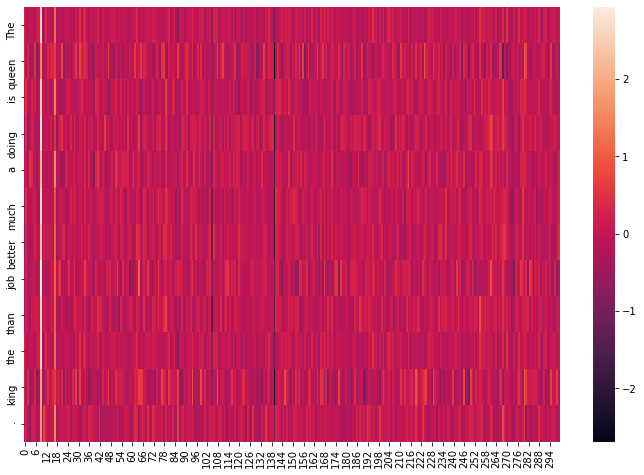

In [505]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[12, 8])
sns.heatmap(vectors, yticklabels=[token.text for token in tokens])
plt.show()

Further reading on word vectors

* https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/

# What kind of tasks do people work on?

* Text classification
* Named Entity Recognition
* Part-of-speech tagging
* Question answering
* Entity Linking
* Relation extraction
* Topic modeling
* Language modeling
* Translation - human translation is a 33 billion dollar industry

Benchmarks
* [GLUE](https://gluebenchmark.com/)
* [SuperGLUE](https://super.gluebenchmark.com/tasks/)

# What libraries do people use?

* [scikit-learn](https://scikit-learn.org/stable/index.html)
* [nltk](https://www.nltk.org/index.html)
* [spaCy](https://spacy.io/)
* [fastai](https://www.fast.ai/)
* [PyTorch](https://pytorch.org/) / [HuggingFace](https://huggingface.co/)

# Fun datasets to try

- [ICLR 2021 Abstracts with Scores](https://github.com/evanzd/ICLR2021-OpenReviewData)
- [IMDb dataset](https://ai.stanford.edu/~amaas/data/sentiment/)
- [Jeopardy! questions](http://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/)
- [List of datasets](https://github.com/niderhoff/nlp-datasets)

# Further reading

* http://web.stanford.edu/class/cs224n/
* https://github.com/fastai/course-nlp
* http://norvig.com/ngrams/
* [The shallowness of Google translate](https://www.theatlantic.com/technology/archive/2018/01/the-shallowness-of-google-translate/551570/) - we still have some way to go!

# Thanks!

## Example reviews

In [473]:
print(pos['20_9'])

'Stanley and Iris' show the triumph of the human spirit. For Stanley, it's the struggle to become literate and realize his potential. For Iris, it's to find the courage to love again after becoming a widow. The beauty of the movie is the dance that Robert DeNiro and Jane Fonda do together, starting and stopping, before each has the skills and courage to completely trust each other and move on. In that sense it very nicely gives us a good view of how life often is, thus being credible. Unlike some other reviewers I found the characters each rendered to be consistent for the whole picture. The supporting cast is also carefully chosen and they add a depth of character that the main characters get added meaning from the supporting performances. All in all an excellent movie. The best thing I take from it is Hope.


https://www.imdb.com/title/tt0100680/?ref_=tt_urv
fonda_deniro_Stanley_And_Iris_1990

In [478]:
print(neg['30_1'])

I did not like the idea of the female turtle at all since 1987 we knew the TMNT to be four brothers with their teacher Splinter and their enemies and each one of the four brothers are named after the great artists name like Leonardo , Michelangleo, Raphel and Donatello so Venus here doesn't have any meaning or playing any important part and I believe that the old TMNT series was much more better than that new one which contains Venus As a female turtle will not add any action to the story we like the story of the TMNT we knew in 1987 to have new enemies in every part is a good point to have some action but to have a female turtle is a very weak point to have some action, we wish to see more new of TMNT series but just as the same characters we knew in 1987 without that female turtle.


In [ ]:
https://www.imdb.com/title/tt0127388/?ref_=tt_urv

## ICLR Reviews

In [86]:
# https://github.com/evanzd/ICLR2021-OpenReviewData
import h5py

f = h5py.File('data_20191223155942.hdf5', 'r')

papers = {}
groups_str = [
    'title', 'abstract', 'decision', 'keyword', 'url',
]
groups_num = [
    'desk_reject', 'meta_review_len', 'rating', 'review_len', 'withdrawn'
]
for paper_id in f.keys():
    paper = {}
    
    # scalar strings
    for key in groups_str + groups_num:
        paper[key] = f[paper_id][key][()]
        if key in groups_str:
            paper[key] = paper[key].decode()
    if ('rating' in paper) and (paper['rating'].shape[0] > 0):
        paper['rating_avg'] = paper['rating'].mean()
    if 'keyword' in paper:
        paper['keyword'] = paper['keyword'].split('#')
    
    
    papers[paper_id] = paper
    
f.close()

In [87]:
# convert to pandas
import pandas as pd
df = pd.DataFrame.from_dict(papers, orient='index')
df.head()

,title,abstract,decision,keyword,url,desk_reject,meta_review_len,rating,review_len,withdrawn,rating_avg
0,Adversarial Training With Voronoi Constraints,Adversarial examples are a pervasive phenomeno...,N/A,"[AdversarialExamples, AdversarialTraining, Vor...",https://openreview.net/forum?id=HJeb9xSYwB,False,0,[],[],True,NaN
1,Towards Stable And Comprehensive Domain Alignm...,Domain adaptation tackles the problem of tra...,Reject,"[DomainAdaptation, TransferLearning, Adversari...",https://openreview.net/forum?id=BklEF3VFPB,False,132,"[3, 6, 3]","[513, 483, 369]",False,4.000000
10,Learning To Remember From A Multi-task Teacher,Recent studies on catastrophic forgetting duri...,Reject,"[MetaLearning, SequentialLearning, Catastrophi...",https://openreview.net/forum?id=rke5R1SFwS,False,366,"[1, 8, 3]","[1327, 613, 1407]",False,4.000000
100,On The Difficulty Of Warm-starting Neural Netw...,In many real-world deployments of machine lear...,Reject,"[DeepLearning, NeuralNetworks]",https://openreview.net/forum?id=ryl0cAVtPH,False,110,"[3, 3, 1]","[532, 353, 595]",False,2.333333
1000,On The Variance Of The Adaptive Learning Rate ...,The learning rate warmup heuristic achieves re...,Accept (Poster),"[Warmup, Adam, Variance]",https://openreview.net/forum?id=rkgz2aEKDr,False,42,"[6, 6, 6]","[105, 355, 87]",False,6.000000
